# 1 day

In [8]:
import numpy as np
import pandas as pd
import netCDF4 as nc4
from netCDF4 import num2date
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from netCDF4 import Dataset

In [ ]:
# Ruta del archivo .nc
ncFileName = '/disk/barbusano/barbusano1/Projects/Waves/IAwave/Tania_TFG/Datos/Datos_Albano_Modelo/wave_wind_20_23_filtered_3y.nc'

# Leer los datos del archivo .nc
with nc4.Dataset(ncFileName, mode='r') as ncfid:
    # Extraer variables
    time = ncfid.variables['valid_time'][:]
    lat = ncfid.variables['latitude'][:]
    lon = ncfid.variables['longitude'][:]
    u10 = ncfid.variables['u10'][:]
    v10 = ncfid.variables['v10'][:]

    time_units = ncfid.variables['valid_time'].units
    time_calendar = ncfid.variables['valid_time'].calendar if hasattr(ncfid.variables['valid_time'], 'calendar') else 'standard'


    time_dates = num2date(time, units=time_units, calendar=time_calendar)
    time_dates_dt = [datetime(date.year, date.month, date.day) for date in time_dates]

# Verificar dimensiones
print("Dimensions of the variables:")
print(f"time: {time.shape}, lat: {lat.shape}, lon: {lon.shape}")
print(f"u10: {u10.shape}, v10: {v10.shape}")

# Ruta del archivo CSV con datos de la boya
csvFileName = '/disk/barbusano/barbusano1/Projects/Waves/IAwave/Tania_TFG/Datos/Boya Tenerife Sur/DailyWaveStats_4p_20_23_TS.csv'

# Leer datos de la boya
df = pd.read_csv(csvFileName, sep=',', decimal='.', encoding='utf-8')

# Seleccionar las columnas de interés
target_cols = ['hmean (m)', 'Tpico_mean (s)', 'Dir_procedencia_mean']
y = df[target_cols].astype(float).values

# Verificar las primeras filas de y
print("First 5 rows of y:")
print(y[:5])

# DataFrame con fechas del .nc
df_nc = pd.DataFrame({'Fecha': time_dates_dt})
df_nc['Fecha'] = pd.to_datetime(df_nc['Fecha'])
df_nc.set_index('Fecha', inplace=True)

# DataFrame con u10 y v10 indexados por fecha
df_nc_indexed = pd.DataFrame(index=df_nc.index)
df_nc_indexed['u10'] = list(u10[:, 93, 88])  # Obtener solo el viento en el píxel (93, 88)
df_nc_indexed['v10'] = list(v10[:, 93, 88])

# DataFrame original de la boya
df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True)
df_merged = pd.merge(df, df_nc_indexed, left_on='Fecha', right_index=True)

# Ordenar por fecha
df_merged.sort_values('Fecha', inplace=True)
df_merged.reset_index(drop=True, inplace=True)

# Preparar datos de entrada (X) y salida (y)
X = np.array([np.sqrt(u10_t**2 + v10_t**2) for u10_t, v10_t in zip(df_merged['u10'], df_merged['v10'])])
y = df_merged[target_cols].values

# Verificación
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")


Dimensions of the variables:
time: (6879,), lat: (128,), lon: (128,)
u10: (6879, 128, 128), v10: (6879, 128, 128)
First 5 rows of y:
[[ 1.46   9.395 87.   ]
 [ 1.555  5.96  88.5  ]
 [ 1.445  5.615 89.   ]
 [ 1.26   4.85  89.5  ]
 [ 1.11   8.505 93.   ]]
Shape of X: (6879,)
Shape of y: (6879, 3)


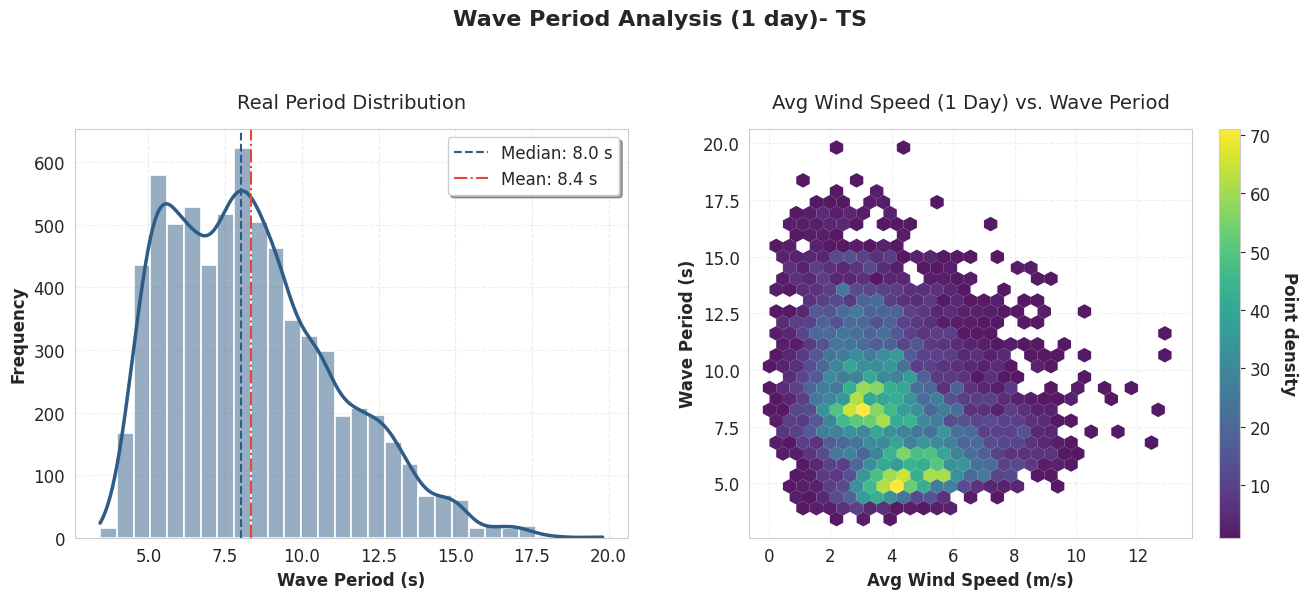

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelweight': 'bold',
    'grid.linestyle': '--',
    'grid.alpha': 0.4,
    'figure.facecolor': 'white'
})


fig = plt.figure(figsize=(14, 6))
fig.suptitle('Wave Period Analysis (1 day)- TS', 
             fontsize=16, fontweight='bold', y=1.05)


ax1 = plt.subplot(1, 2, 1)

# Histograma
hist = sns.histplot(
    x=y[:,1],  # Periodo de las olas
    bins=30,
    kde=True,
    color='#2e5c87',
    edgecolor='white',
    linewidth=1.2,
    line_kws={  # Parámetros de KDE
        'color': '#e34a33',
        'linewidth': 2.5,
        'linestyle': '-'
    }
)


median = np.median(y[:,1])
mean = np.mean(y[:,1])
ax1.axvline(median, color='#2e5c87', linestyle='--', linewidth=1.5, 
            label=f'Median: {median:.1f} s')
ax1.axvline(mean, color='#e34a33', linestyle='-.', linewidth=1.5,
            label=f'Mean: {mean:.1f} s')


ax1.set_title("Real Period Distribution", pad=15)
ax1.set_xlabel("Wave Period (s)", fontweight='semibold')
ax1.set_ylabel("Frequency", fontweight='semibold')
ax1.legend(frameon=True, shadow=True, loc='upper right')
ax1.grid(axis='y', alpha=0.3)


ax2 = plt.subplot(1, 2, 2)

# Gráfico de densidad hexagonal
hexbin = ax2.hexbin(
    X,  # Velocidad del viento en el píxel (93, 88)
    y[:,1],  # Periodo de las olas
    gridsize=30,
    cmap='viridis',
    mincnt=1,
    edgecolors='none',
    alpha=0.9
)


cbar = plt.colorbar(hexbin, ax=ax2)
cbar.set_label('Point density', rotation=270, labelpad=20, fontweight='semibold')
ax2.set_title("Avg Wind Speed (1 Day) vs. Wave Period", pad=15)
ax2.set_xlabel("Avg Wind Speed (m/s)", fontweight='semibold')
ax2.set_ylabel("Wave Period (s)", fontweight='semibold')
ax2.grid(alpha=0.3)


plt.tight_layout(pad=3)
plt.subplots_adjust(top=0.85)


plt.savefig(
    'period_relation_1day.png', 
    dpi=300, 
    bbox_inches='tight',
    facecolor='white'
)

plt.show()

# 6 days

In [ ]:
# Load NetCDF file
nc_path = '/disk/barbusano/barbusano1/Projects/Waves/IAwave/Tania_TFG/Datos/Datos_Albano_Modelo/wave_wind_2000_2023_128x128_filtered_tfs_5days.nc'

with Dataset(nc_path, mode='r') as ncfile:
    u_wind = []
    v_wind = []
    for day in range(6):
        u = ncfile.variables[f'u{day}'][:, 93, 88]
        v = ncfile.variables[f'v{day}'][:, 93, 88]
        u_wind.append(u)
        v_wind.append(v)

    # (n_samples, 6)
    u_stack = np.stack(u_wind, axis=1)
    v_stack = np.stack(v_wind, axis=1)

    wind_speed_avg = np.sqrt(u_stack**2 + v_stack**2).mean(axis=1)


csv_path = '/disk/barbusano/barbusano1/Projects/Waves/IAwave/Tania_TFG/Datos/Boya Tenerife Sur/DailyWaveStats_4p_20_23_TS.csv'
df_wave = pd.read_csv(csv_path, sep=',', decimal='.', encoding='utf-8')


df_wave['Fecha'] = pd.to_datetime(df_wave['Fecha'], dayfirst=True)
periods = df_wave['Tpico_mean (s)'].astype(float).values


min_len = min(len(wind_speed_avg), len(periods))
periods = periods[:min_len]
wind_speed_avg = wind_speed_avg[:min_len]



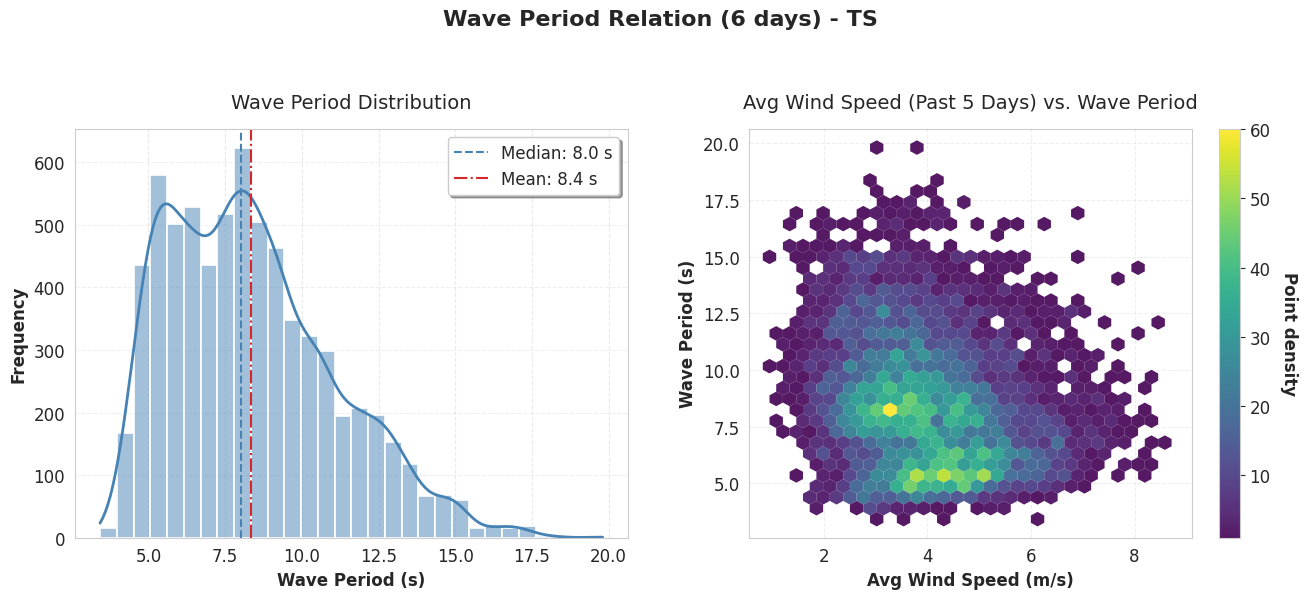

In [ ]:
sns.set_style("whitegrid")
sns.set_palette("muted")
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelweight': 'bold',
    'grid.linestyle': '--',
    'grid.alpha': 0.4,
    'figure.facecolor': 'white'
})

fig = plt.figure(figsize=(14, 6))
fig.suptitle('Wave Period Relation (6 days) - TS',
             fontsize=16, fontweight='bold', y=1.05)


ax1 = plt.subplot(1, 2, 1)
sns.histplot(
    x=periods,
    bins=30,
    kde=True,
    color='#4682B4',
    edgecolor='white',
    linewidth=1.2,
    line_kws={'color': '#d62728', 'linewidth': 2}
)
median = np.median(periods)
mean = np.mean(periods)
ax1.axvline(median, color='#4682B4', linestyle='--', linewidth=1.5,
            label=f'Median: {median:.1f} s')
ax1.axvline(mean, color='#d62728', linestyle='-.', linewidth=1.5,
            label=f'Mean: {mean:.1f} s')
ax1.set_title("Wave Period Distribution", pad=15)
ax1.set_xlabel("Wave Period (s)", fontweight='semibold')
ax1.set_ylabel("Frequency", fontweight='semibold')
ax1.legend(frameon=True, shadow=True, loc='upper right')
ax1.grid(axis='y', alpha=0.3)


ax2 = plt.subplot(1, 2, 2)
hexbin = ax2.hexbin(
    wind_speed_avg,
    periods,
    gridsize=30,
    cmap='viridis',
    mincnt=1,
    edgecolors='none',
    alpha=0.9
)
cbar = plt.colorbar(hexbin, ax=ax2)
cbar.set_label('Point density', rotation=270, labelpad=20, fontweight='semibold')
ax2.set_title("Avg Wind Speed (Past 5 Days) vs. Wave Period", pad=15)
ax2.set_xlabel("Avg Wind Speed (m/s)", fontweight='semibold')
ax2.set_ylabel("Wave Period (s)", fontweight='semibold')
ax2.grid(alpha=0.3)

plt.tight_layout(pad=3)
plt.subplots_adjust(top=0.85)
plt.savefig('period_relation_6days.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


# Valor Real csv vs. Valor Modelo nCDF

In [8]:
import numpy as np
import pandas as pd
import netCDF4 as nc4
from netCDF4 import num2date
from datetime import datetime

# Ruta al archivo con pp1d
ncFileName = '/disk/barbusano/barbusano1/Projects/Waves/IAwave/Tania_TFG/Datos/Datos_Albano_Modelo/ERA5_waveall_point_16.5W_28N_2003_2023_filtered.nc'

# Leer el archivo NetCDF
with nc4.Dataset(ncFileName, mode='r') as ncfid:
    time = ncfid.variables['valid_time'][:]
    time_units = ncfid.variables['valid_time'].units
    time_calendar = ncfid.variables['valid_time'].calendar if hasattr(ncfid.variables['valid_time'], 'calendar') else 'standard'
    time_dates = num2date(time, units=time_units, calendar=time_calendar)
    time_dates_dt = [datetime(d.year, d.month, d.day) for d in time_dates]

    pp1d = ncfid.variables['pp1d'][:]  # (6879, 1, 1)
    print("Shape of pp1d:", pp1d.shape)
    pp_values = pp1d[:, 0, 0]  # ✅ Extraer correctamente como 1D

# Crear DataFrame del modelo
df_model = pd.DataFrame({
    'Fecha': pd.to_datetime(time_dates_dt),
    'pp_model': pp_values
})
df_model.set_index('Fecha', inplace=True)

# === CSV de la boya ===
csvFileName = '/disk/barbusano/barbusano1/Projects/Waves/IAwave/Tania_TFG/Datos/Boya Tenerife Sur/DailyWaveStats_4p_20_23_TS.csv'
df_boya = pd.read_csv(csvFileName, sep=',', decimal='.', encoding='utf-8')
df_boya['Fecha'] = pd.to_datetime(df_boya['Fecha'], dayfirst=True)

# Extraer columna de periodo de pico y renombrarla
df_boya_period = df_boya[['Fecha', 'Tpico_mean (s)']]
df_boya_period.rename(columns={'Tpico_mean (s)': 'pp_real'}, inplace=True)
df_boya_period.set_index('Fecha', inplace=True)

# === Combinar con datos del modelo ===
df_comp = pd.merge(df_boya_period, df_model, left_index=True, right_index=True)

# Verificación opcional
print(df_comp.head())


Shape of pp1d: (6879, 1, 1)
            pp_real   pp_model
Fecha                         
2003-05-06    9.395   6.506203
2003-05-07    5.960   8.078835
2003-05-08    5.615   9.748024
2003-05-09    4.850  10.523537
2003-05-10    8.505   8.357643


/tmp/ipykernel_2004751/3076927825.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_boya_period.rename(columns={'Tpico_mean (s)': 'pp_real'}, inplace=True)


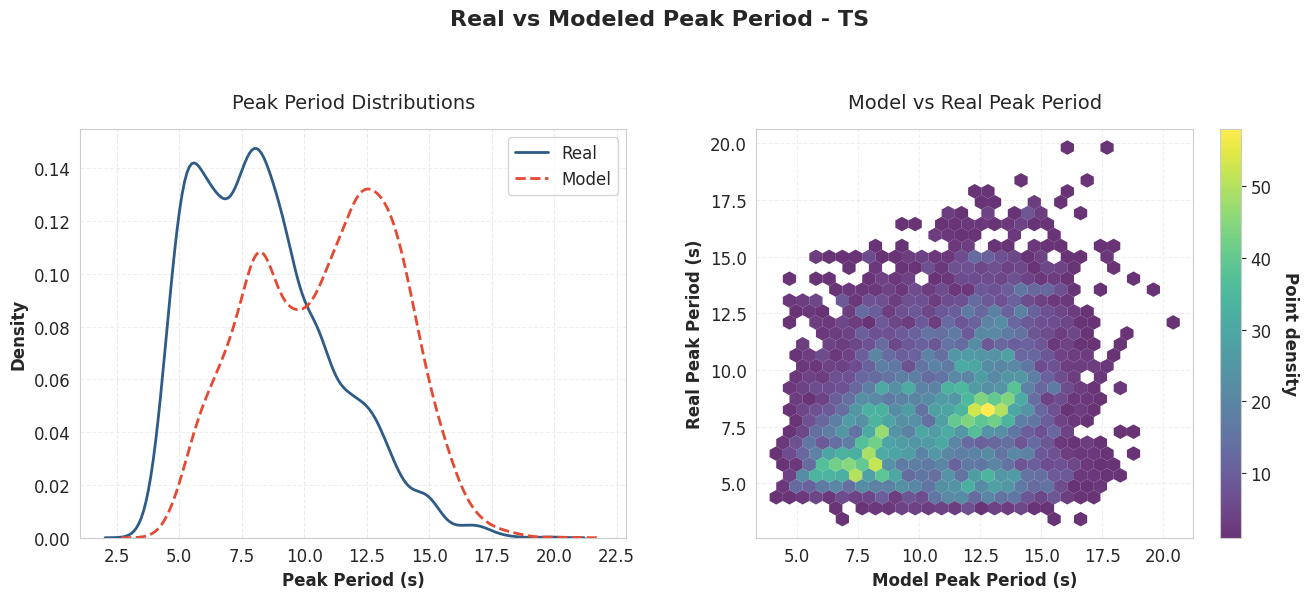

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette("Set2")
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelweight': 'bold',
    'grid.linestyle': '--',
    'grid.alpha': 0.4,
    'figure.facecolor': 'white'
})

fig = plt.figure(figsize=(14, 6))
fig.suptitle('Real vs Modeled Peak Period - TS', 
             fontsize=16, fontweight='bold', y=1.05)

# KDE Plot
ax1 = plt.subplot(1, 2, 1)
sns.kdeplot(df_comp['pp_real'], label='Real', color='#2e5c87', linewidth=2)
sns.kdeplot(df_comp['pp_model'], label='Model', color='#e34a33', linewidth=2, linestyle='--')
ax1.set_title("Peak Period Distributions", pad=15)
ax1.set_xlabel("Peak Period (s)", fontweight='semibold')
ax1.set_ylabel("Density", fontweight='semibold')
ax1.legend(frameon=True, loc='upper right')
ax1.grid(axis='y', alpha=0.3)

# Hexbin Plot
ax2 = plt.subplot(1, 2, 2)
hexbin = ax2.hexbin(
    df_comp['pp_model'],
    df_comp['pp_real'],
    gridsize=30,
    cmap='viridis',
    mincnt=1,
    edgecolors='none',
    alpha=0.8
)
cbar = plt.colorbar(hexbin, ax=ax2)
cbar.set_label('Point density', rotation=270, labelpad=20, fontweight='semibold')
ax2.set_title("Model vs Real Peak Period", pad=15)
ax2.set_xlabel("Model Peak Period (s)", fontweight='semibold')
ax2.set_ylabel("Real Peak Period (s)", fontweight='semibold')
ax2.grid(alpha=0.3)

# Final layout and save
plt.tight_layout(pad=3)
plt.subplots_adjust(top=0.85)
plt.savefig('real_vs_model_wave_period.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()